In [3]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [('ZZ', [i, i + 1], -J) for i in range(0, L-1)]
    Z_tuples = [('Z', [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [('X', [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [39]:
from math import pi

H = get_hamiltonian(L=2, J=.2, h=1., alpha=pi/8)

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

In [40]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

final_time = 1.6

# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label('10')

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

In [41]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

c:\Users\Tim\.conda\envs\qiskit\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


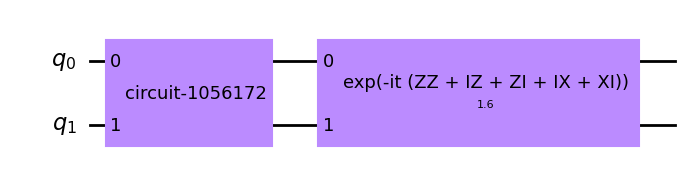

In [42]:
result.evolved_state.draw('mpl')

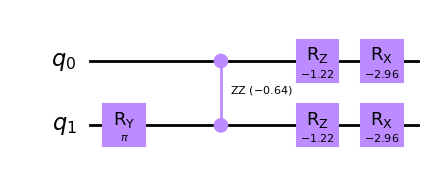

In [43]:
result.evolved_state.decompose(reps=2).decompose('disentangler_dg').decompose('multiplex1_reverse_dg').draw('mpl')

In [44]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([ 0.02895926+0.08738739j, -0.9411211 +0.31187756j,
              0.00811432-0.002689j  ,  0.02895926+0.08738739j],
            dims=(2, 2))


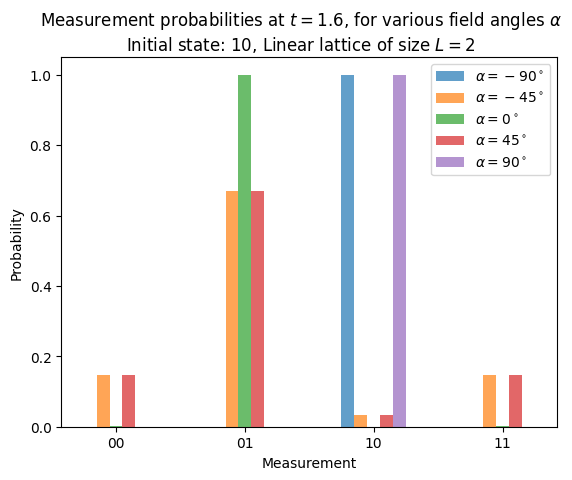

In [45]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = .1
# We prepare an initial state ↑↓ (01).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_state = Statevector.from_label("10")
trotter = TrotterQRTE()
final_time = 1.6
eps = 1e-5

# We create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L=2, J=.2, h=1., alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

In [46]:
from math import pi

L = 6
H = get_hamiltonian(L=L, J=.2, h=1.2, alpha=pi/8)

In [47]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

In [48]:
magnetization_op = SparsePauliOp.from_sparse_list([('Z', [i], 1.) for i in range(0, L)], num_qubits=L)
correlation_op = SparsePauliOp.from_sparse_list([('ZZ', [i, i+1], 1.) for i in range(0, L-1)], num_qubits=L) / (L - 1)

In [49]:
final_time = 30.
initial_state = Statevector.from_label('001100')
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])

In [50]:
result = trotter.evolve(problem)

In [51]:
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 3)

Text(0.5, 0.98, 'Observable evolution')

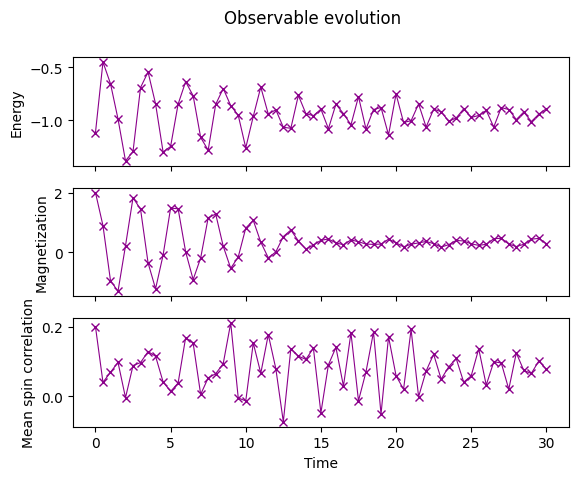

In [72]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state
axes[0].plot(times, observables[:, 0], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[1].plot(times, observables[:, 1], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[2].plot(times, observables[:, 2], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

In [53]:
import scipy as sc

H_array = H.to_matrix()

# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]

In [54]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

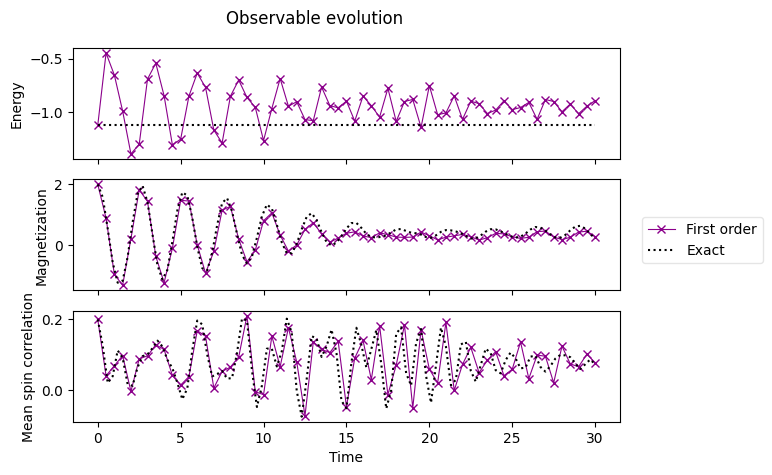

In [73]:
axes[0].plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
axes[1].plot(exact_times, exact_magnetization, c='k', ls=':', label='Exact')
axes[2].plot(exact_times, exact_correlation, c='k', ls=':', label='Exact')
# Select the labels of only the first axis
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig.tight_layout()
fig


Trotter step with Lie-Trotter
-----------------------------

                  Depth: 7
             Gate count: 17
    Nonlocal gate count: 5
         Gate breakdown: RZ: 6, RX: 6, RZZ: 5



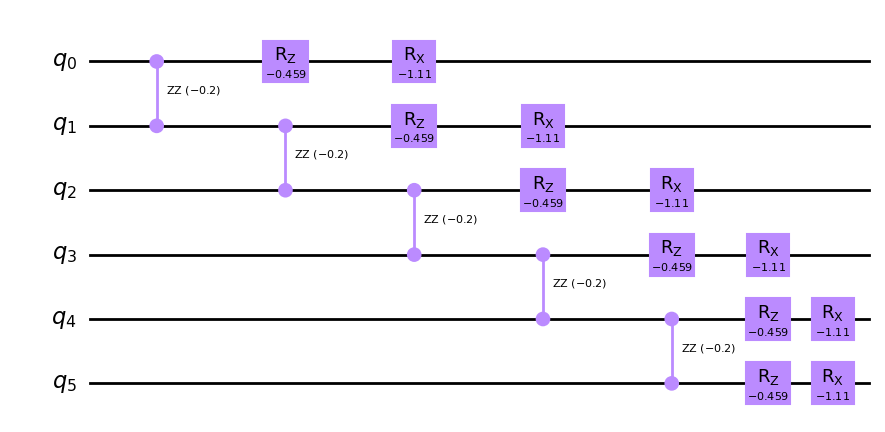

In [56]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
dt = final_time / num_timesteps
trotter_step_first_order = PauliEvolutionGate(H, dt, synthesis=LieTrotter())

# We create an empty circuit
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Lie-Trotter
-----------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
""")

# And finally draw the circuit
circuit.draw('mpl')


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 14
             Gate count: 33
    Nonlocal gate count: 10
         Gate breakdown: RZ: 12, RX: 11, RZZ: 10




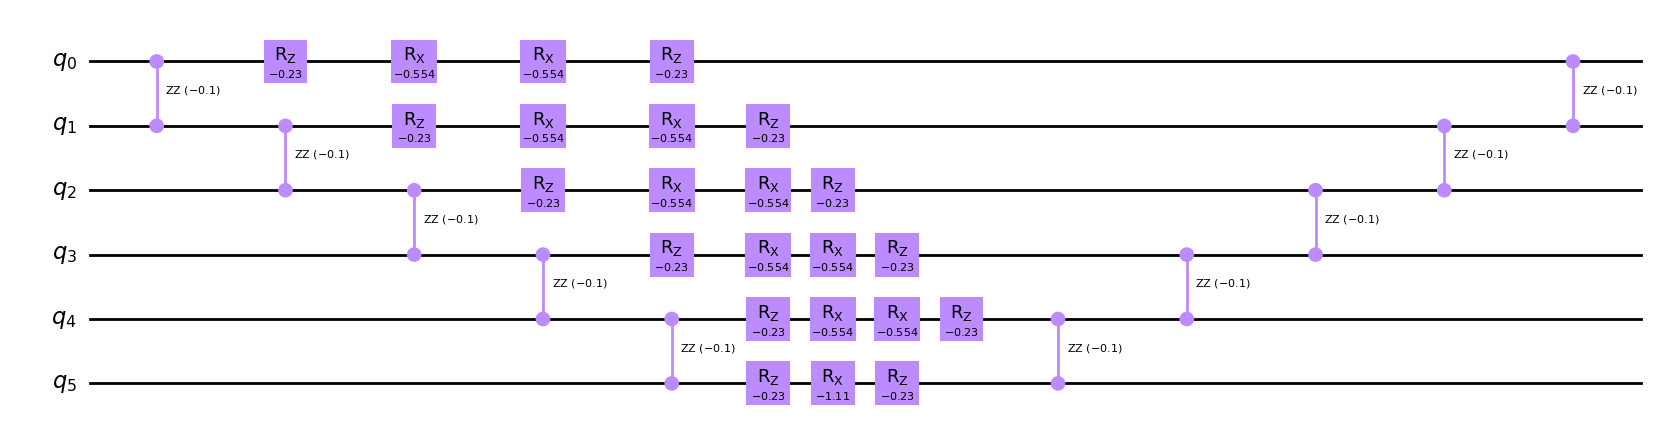

In [57]:
from qiskit.synthesis import SuzukiTrotter

second_order_formula = SuzukiTrotter() # if not passed, order defaults to 2
trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_second_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

""")

# And finall
circuit.draw('mpl')

In [66]:
fourth_order_formula = SuzukiTrotter(order=4)
trotter_step_fourth_order = PauliEvolutionGate(H, dt, synthesis=fourth_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_fourth_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

""")


Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: 70
             Gate count: 165
    Nonlocal gate count: 50
         Gate breakdown: RZ: 60, RX: 55, RZZ: 50




In [67]:
from qiskit.synthesis import SuzukiTrotter

trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])
result = trotter.evolve(problem)
observables_order4 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

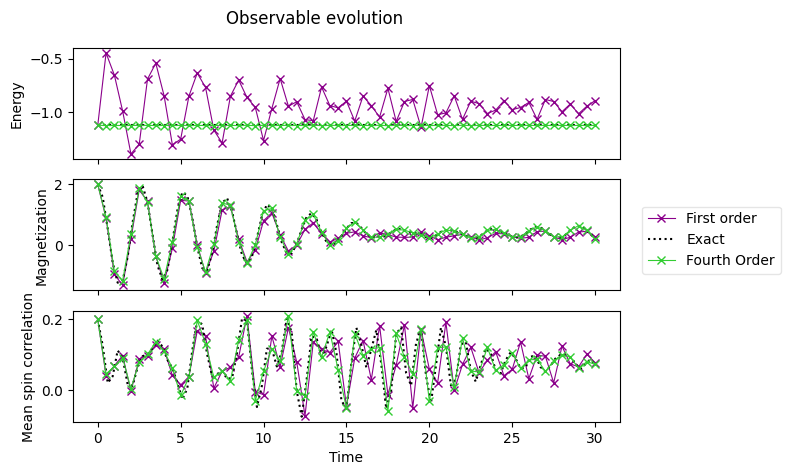

In [74]:
axes[0].plot(times, observables_order4[:, 0], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[1].plot(times, observables_order4[:, 1], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[2].plot(times, observables_order4[:, 2], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)

# Replace the legend
legend.remove()
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig

In [60]:
sixth_order_formula = SuzukiTrotter(order=6)
trotter_step_sixth_order = PauliEvolutionGate(H, dt, synthesis=sixth_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_sixth_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Suzuki Trotter (6th order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

""")


Trotter step with Suzuki Trotter (6th order)
--------------------------------------------

                  Depth: 350
             Gate count: 825
    Nonlocal gate count: 250
         Gate breakdown: RZ: 300, RX: 275, RZZ: 250




In [62]:
from qiskit.synthesis import SuzukiTrotter

trotter = TrotterQRTE(SuzukiTrotter(order=6), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])
result = trotter.evolve(problem)
observables_order6 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

In [63]:
observables_order6=observables_order4

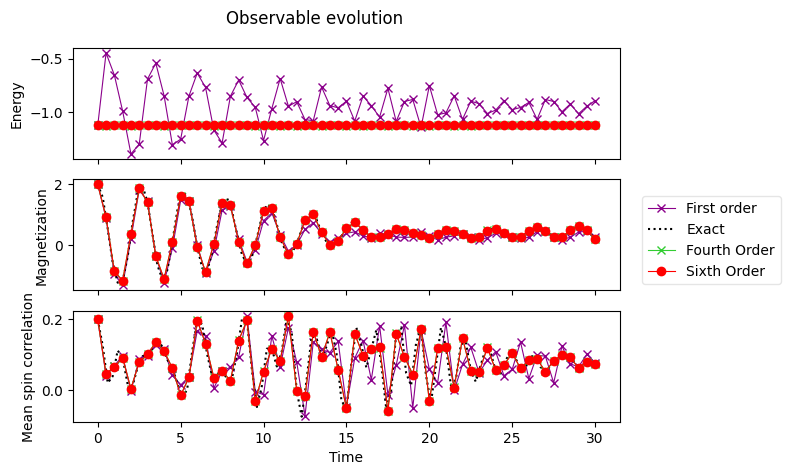

In [75]:
axes[0].plot(times, observables_order6[:, 0], label='Sixth Order', marker='o', c='red', ls='-', lw=.8)
axes[1].plot(times, observables_order6[:, 1], label='Sixth Order', marker='o', c='red', ls='-', lw=.8)
axes[2].plot(times, observables_order6[:, 2], label='Sixth Order', marker='o', c='red', ls='-', lw=.8)

# Replace the legend
legend.remove()
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig

Sixth order unitary has similar result with fourth order, but it take much more time to calculate.

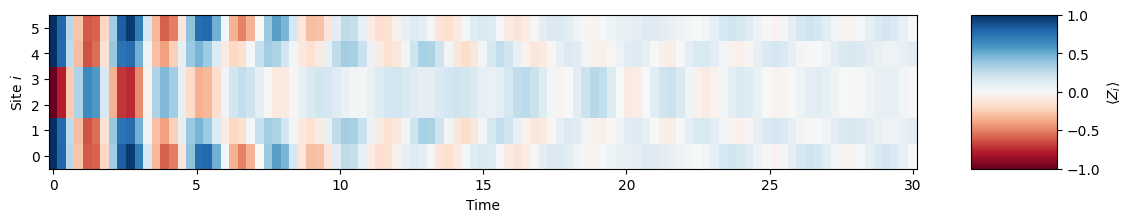

In [ ]:
from matplotlib import cm

# An inner list comprehension loops over the terms of the SparsePauliOp magnetization_op,
# which corresponds to the magnetization of each one of the sites
magnetizations = np.real([[sv.expectation_value(term) for term in magnetization_op] for sv in exact_evolution])
# The shape of magnetizations is (101, 6), containing <Z>(t) for each site 0, 1, ..., 5
plt.figure(figsize=(14, 2))
# Create the 2-dim xx and yy arrays tiling the grid with the x and y values
xx, yy = np.meshgrid(exact_times, np.arange(L))
plt.pcolor(xx, yy, magnetizations.T, vmin=-1, vmax=+1, cmap='RdBu')
# Force the figure to have all y ticks from 0 to 5
plt.yticks(np.arange(L))
plt.ylabel('Site $i$')
plt.xlabel('Time')
plt.colorbar(label='$\\langle Z_i \\rangle$', aspect=1.8)

For 8-site Ising model with trotter algorithm 

In [4]:
from math import pi

L = 8
H = get_hamiltonian(L=L, J=.2, h=1.2, alpha=pi/8)

In [5]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

final_time = 1.6
initial_state = Statevector.from_label('10111010')

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

In [6]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

In [7]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

In [8]:
magnetization_op = SparsePauliOp.from_sparse_list([('Z', [i], 1.) for i in range(0, L)], num_qubits=L)
correlation_op = SparsePauliOp.from_sparse_list([('ZZ', [i, i+1], 1.) for i in range(0, L-1)], num_qubits=L) / (L - 1)

In [9]:
final_time = 30.
initial_state = Statevector.from_label('00001100')
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])

In [10]:
result = trotter.evolve(problem)

In [11]:
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 3)

Text(0.5, 0.98, 'Observable evolution')

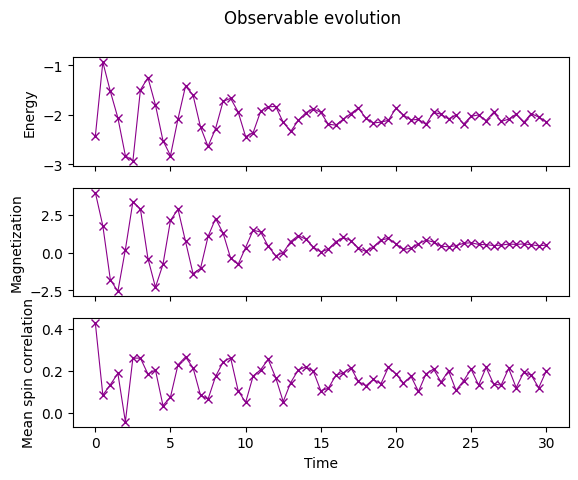

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state
axes[0].plot(times, observables[:, 0], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[1].plot(times, observables[:, 1], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[2].plot(times, observables[:, 2], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

In [13]:
import scipy as sc

H_array = H.to_matrix()
exact_times = np.linspace(0, final_time, 101)
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]

In [15]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

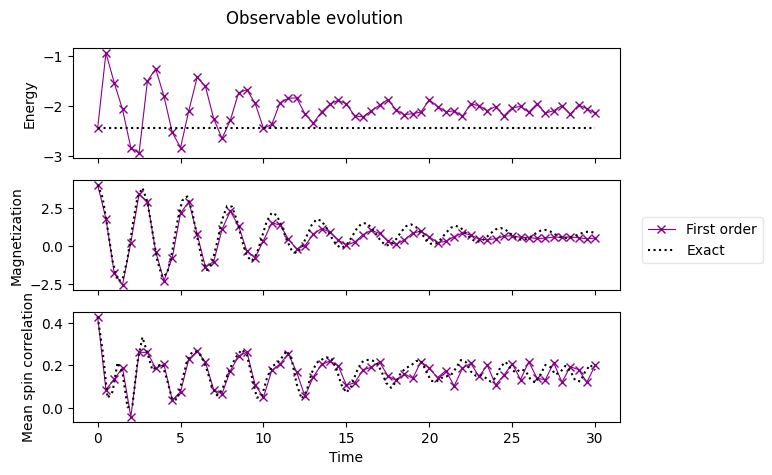

In [16]:
axes[0].plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
axes[1].plot(exact_times, exact_magnetization, c='k', ls=':', label='Exact')
axes[2].plot(exact_times, exact_correlation, c='k', ls=':', label='Exact')
# Select the labels of only the first axis
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig.tight_layout()
fig

In [17]:
from qiskit.synthesis import SuzukiTrotter
trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])
result = trotter.evolve(problem)
observables_order4 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

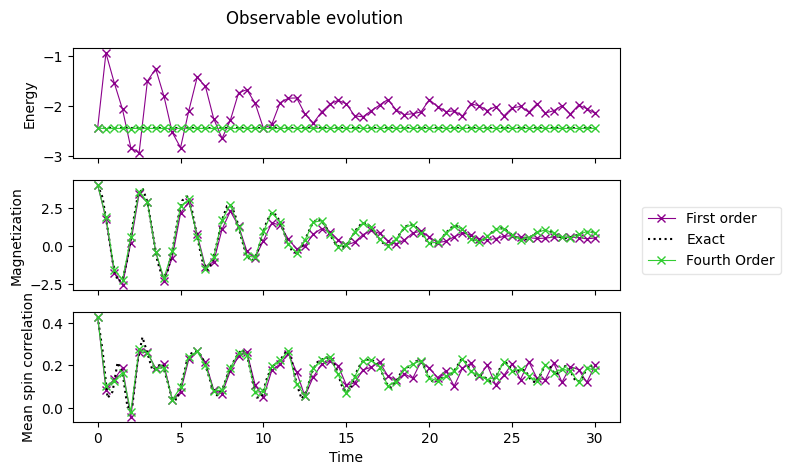

In [18]:
axes[0].plot(times, observables_order4[:, 0], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[1].plot(times, observables_order4[:, 1], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[2].plot(times, observables_order4[:, 2], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)

# Replace the legend
legend.remove()
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig

The result is quite convincing, the more site of Ising model, the lower energy it can be. The magentization also fit with one dimension Ising model, which can't have magentization. We also can see that fourth order is more accurate than first order.

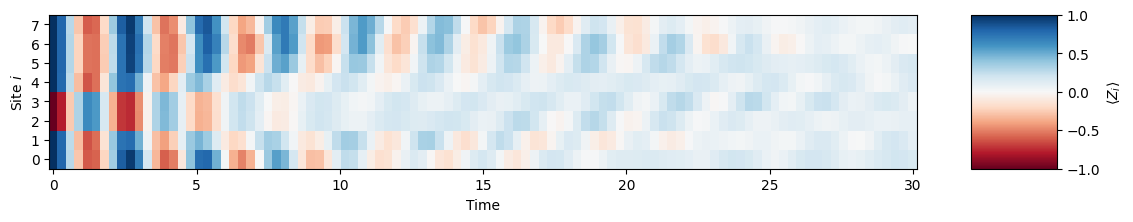

In [19]:
from matplotlib import cm

# An inner list comprehension loops over the terms of the SparsePauliOp magnetization_op,
# which corresponds to the magnetization of each one of the sites
magnetizations = np.real([[sv.expectation_value(term) for term in magnetization_op] for sv in exact_evolution])
# The shape of magnetizations is (101, 6), containing <Z>(t) for each site 0, 1, ..., 5
plt.figure(figsize=(14, 2))
# Create the 2-dim xx and yy arrays tiling the grid with the x and y values
xx, yy = np.meshgrid(exact_times, np.arange(L))
plt.pcolor(xx, yy, magnetizations.T, vmin=-1, vmax=+1, cmap='RdBu')
# Force the figure to have all y ticks from 0 to 5
plt.yticks(np.arange(L))
plt.ylabel('Site $i$')
plt.xlabel('Time')
plt.colorbar(label='$\\langle Z_i \\rangle$', aspect=1.8)